In [102]:
%autoreload 2
%matplotlib ipympl
import os
import glob
import re 
import numpy as np
import matplotlib.pyplot as plt
from qwfs.qwfs_result import QWFSResult
from qwfs.qwfs_simulation import QWFSSimulation
from qwfs.qwfs_utils import get_slm1_intensities 

DATA_DIR = os.path.join(os.path.abspath(os.path.curdir), 'data')

# 1) Assert analytic results agree with autograd-BFGS
## 1.1 the enhancement is similar

---- SLM1-only-T ----
-- unitary --
autograd-adam             0.785+-0.01
analytic                  0.785+-0.01
-- gaus_iid --
autograd-adam             0.785+-0.05
analytic                  0.785+-0.05

---- SLM2-simple ----
-- unitary --
autograd-adam             0.621+-0.02
analytic                  0.621+-0.02
-- gaus_iid --
autograd-adam             0.623+-0.06
analytic                  0.623+-0.06

---- SLM2-simple-OPC ----
-- unitary --
autograd-adam             1.000+-0.00
analytic                  1.000+-0.00
-- gaus_iid --
autograd-adam             1.010+-0.14
analytic                  1.010+-0.14



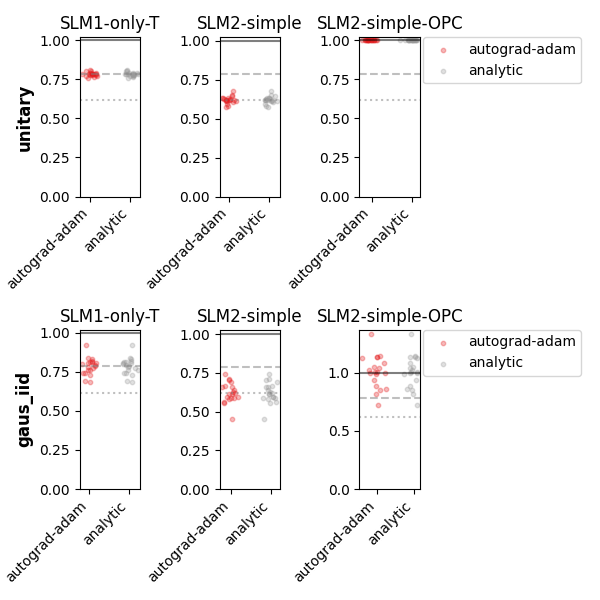

In [5]:
path = glob.glob(rf'{DATA_DIR}\*adam_vrs_analytic*')[-1]
res = QWFSResult(path)
res.print()
res.show_scatterplots()
plt.show()

## 1.2 the actual found phases are the same
ADAM finds the optimal phases for N=256

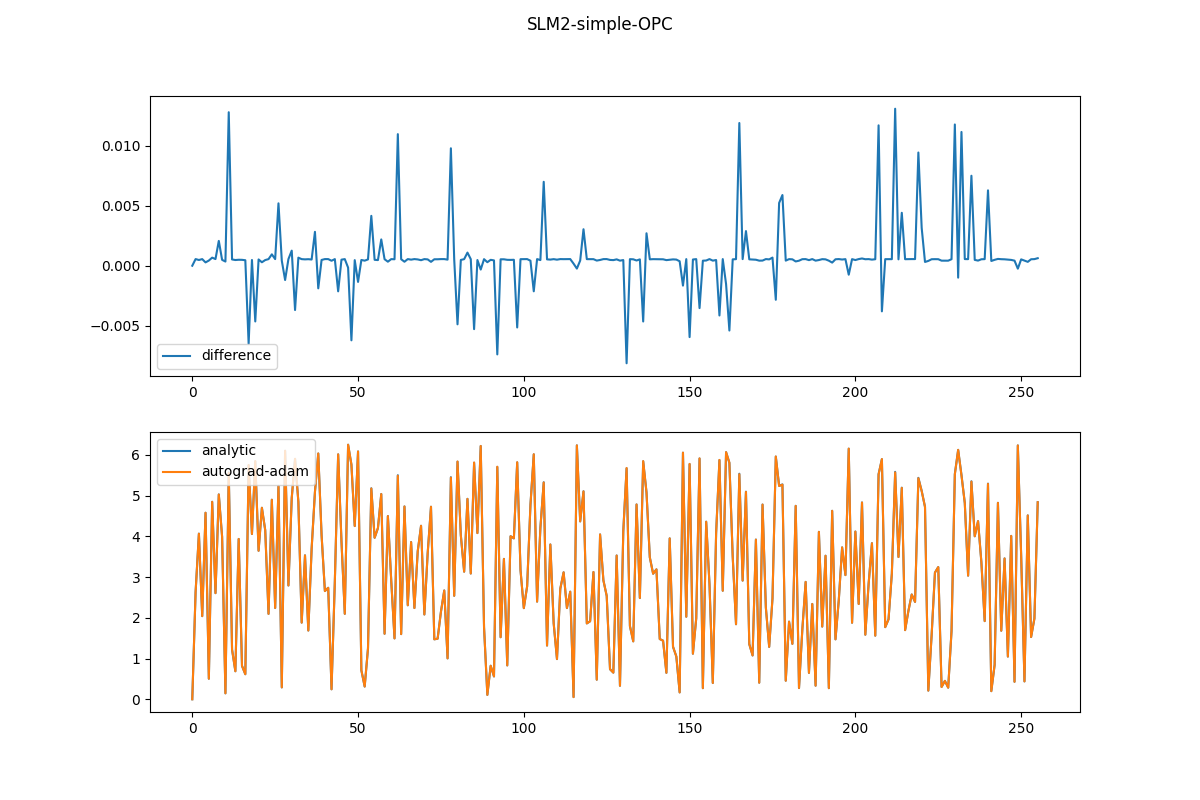

In [37]:
path = glob.glob(rf'{DATA_DIR}\*_compare_vrs_analytic*')[-1]
res = QWFSResult(path)

T_method = 'unitary'
config = 'SLM2-simple-OPC'
try_no = np.random.randint(1, res.N_tries)
try_no=0
phases_analytic = res.get_phases(config=config, T_method=T_method, alg='analytic', try_no=try_no)
phases_adam = res.get_phases(config=config, T_method=T_method, alg='autograd-adam', try_no=try_no)

phases_analytic -= phases_analytic[0]
phases_adam -= phases_adam[0]

phases_analytic = phases_analytic % (2*np.pi)
phases_adam = phases_adam % (2*np.pi)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle(config)
axes[1].plot(phases_analytic, label='analytic')
axes[1].plot(phases_adam, label='autograd-adam')
axes[1].legend()

axes[0].plot(phases_analytic - phases_adam, label='difference')
axes[0].legend()

## 1.3 adding the FFTs does not change things 
SLM3 configuration will use FFTs, etc. so we make sure that also SLM1 and SLM2 in these slightly more complex configurations show the same results. 

In [40]:
path = glob.glob(rf'{DATA_DIR}\*adam_SLM1_SLM2_with_FFTs*')[-1]
res = QWFSResult(path)
res.print()

---- SLM1 ----
-- unitary --
autograd-adam             0.784+-0.02
-- gaus_iid --
autograd-adam             0.793+-0.08

---- SLM2 ----
-- unitary --
autograd-adam             0.623+-0.03
-- gaus_iid --
autograd-adam             0.621+-0.07

---- SLM2-same-mode ----
-- unitary --
autograd-adam             1.000+-0.00
-- gaus_iid --
autograd-adam             1.005+-0.12



# 2) comparing optimizers
See logs in the generate_results notebook. It could be seen that the runtimes of different optimizers scale differently. Most notably:
 
* Simulated annealing, which is supposed to be better at finding a global optimum takes much longer, and scales badly with the size of the system, and does not show consistent better enhancement.
* Using the autograd engine, which uses analytical gradient data, speeds things up significantly, and also achieves better performance.
* The LBFGS pytorch optimizer performs slightly better than the ADAM pytorch optimizer, and takes only ~4X longer, so we would use it. 

# 3) numerical SLM3 results
From these results we quote the approximate SLM3 results 

In [50]:
path = glob.glob(rf'{DATA_DIR}\*SLM3*tries*')[-1]
res = QWFSResult(path)
res.print()
# res.show_scatterplots()

---- SLM3 ----
-- unitary --
autograd-adam             0.877+-0.01
autograd-lbfgs            0.881+-0.01
-- gaus_iid --
autograd-adam             1.864+-0.08
autograd-lbfgs            1.870+-0.08

---- SLM3-same-mode ----
-- unitary --
autograd-adam             1.000+-0.00
autograd-lbfgs            1.000+-0.00
-- gaus_iid --
autograd-adam             4.517+-0.18
autograd-lbfgs            4.540+-0.19



# 4) SLM3 full data example 

I_in.sum()=1.0
I_middle_optimized.sum()=1.8004273548427263
I_out_optimized.sum()=3.08310104572121


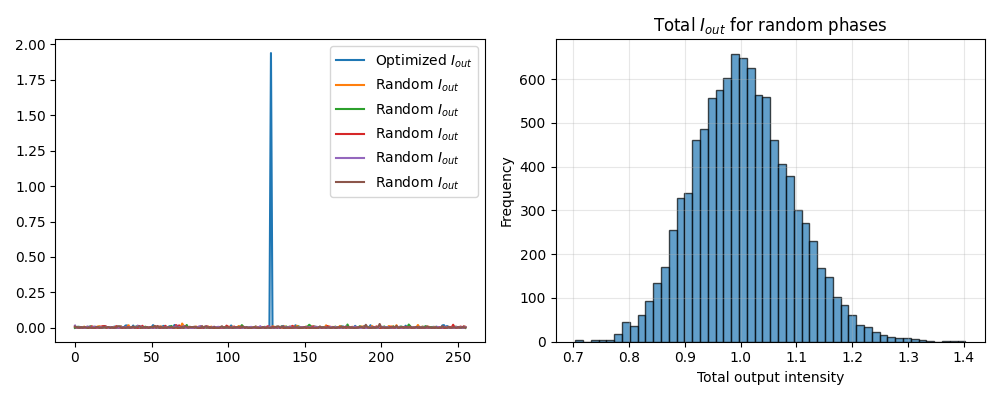

In [79]:
path = glob.glob(rf'{DATA_DIR}\*SLM3_full_data*')[-1]
res = QWFSResult(path)

# Set simulation 
try_no = np.random.randint(res.N_tries)
# try_no = 5
alg = 'autograd-lbfgs'
# config = 'SLM3-same-mode'
config = 'SLM3'
T_method = 'gaus_iid'
# T_method = 'unitary'
alg_ind = np.where(res.algos == alg)[0]
conf_ind = np.where(res.configs == config)[0]
T_method_ind = np.where(res.T_methods == T_method)[0] 
T_ind = res.N_T_methods * try_no + T_method_ind 
T = res.Ts[T_ind].squeeze()
slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
N = len(slm_phases)

sim = QWFSSimulation(N=N)
sim.T = T 
sim.slm_phases = np.exp(1j*slm_phases)
sim.config = config

# get relevant information 
v_out = sim.propagate()
I_out_optimized = np.abs(v_out)**2
I_in = np.abs(sim.v_in)**2
v_middle = sim.T.transpose() @ (sim.slm_phases * sim.v_in)
I_middle_optimized = np.abs(v_middle)**2

print(f'{I_in.sum()=}')
print(f'{I_middle_optimized.sum()=}')
print(f'{I_out_optimized.sum()=}')


tot_Is = []
for i in range(10000):
    random_phases = np.random.uniform(0, 2*np.pi, sim.N)
    sim.slm_phases = np.exp(1j*random_phases)
    v_out = sim.propagate()
    I_out = np.abs(v_out)**2
    tot_Is.append(I_out.sum())
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(I_out_optimized, label='Optimized $I_{out}$')
for i in range(5):
    random_phases = np.random.uniform(0, 2*np.pi, sim.N)
    sim.slm_phases = np.exp(1j*random_phases)
    v_out = sim.propagate()
    I_out = np.abs(v_out)**2
    ax1.plot(I_out, label='Random $I_{out}$')

ax1.legend()

# Create the histogram
ax2.hist(tot_Is, bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Total $I_{out}$ for random phases')
ax2.set_xlabel('Total output intensity')
ax2.set_ylabel('Frequency')

show_mean = False
if show_mean:
    ax2.axvline(np.mean(tot_Is), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(tot_Is):.2f}')
    ax2.axvline(np.median(tot_Is), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(tot_Is):.2f}')

ax2.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()

# 5) 0, $\pi$ phases in SLM3 OPC

Text(0, 0.5, 'phase (rad)')

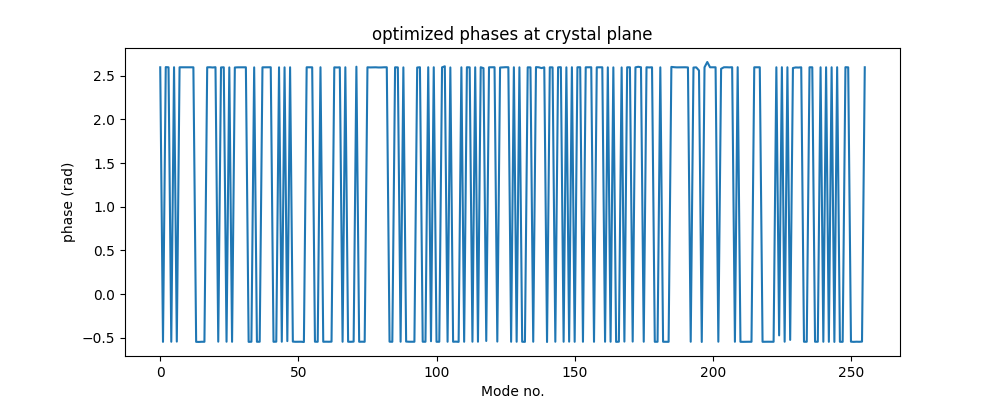

In [101]:
path = glob.glob(rf'{DATA_DIR}\*SLM3_full_data*')[-1]
res = QWFSResult(path)

alg = 'autograd-lbfgs'
config = 'SLM3-same-mode'
# T_method = 'gaus_iid'
T_method = 'unitary'
# try_no = np.random.randint(res.N_tries)
try_no = 0

alg_ind = np.where(res.algos == alg)[0]
conf_ind = np.where(res.configs == config)[0]
T_method_ind = np.where(res.T_methods == T_method)[0]

T_ind = res.N_T_methods * try_no + T_method_ind
T = res.Ts[T_ind].squeeze()
slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
N = len(slm_phases)

sim = QWFSSimulation(N=N)
sim.T = T
sim.slm_phases = np.exp(1j * slm_phases)
sim.config = config

E_middle = sim.T.transpose() @ (sim.slm_phases * sim.v_in)
phases = np.angle(E_middle)
# I_middle = np.abs(E_middle) ** 2
# I_out = np.abs(sim.propagate()) ** 2


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(phases)
ax.set_title(f'optimized phases at crystal plane')
ax.set_xlabel('Mode no.')
ax.set_ylabel('phase (rad)')

# 6) Figure 3 - results summary

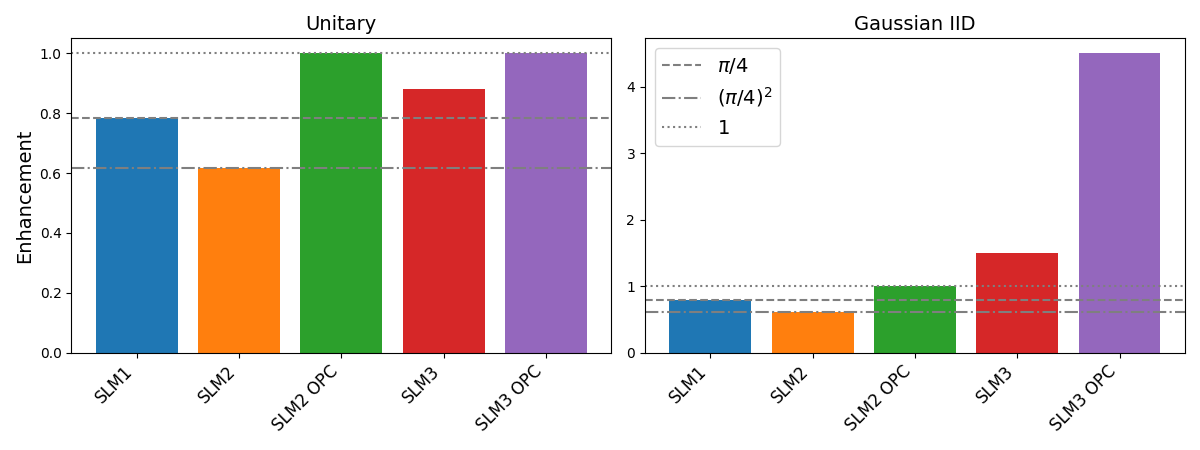

In [61]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["SLM1", "SLM2", "SLM2 OPC", "SLM3", "SLM3 OPC"]
unitary_data = [np.pi / 4, (np.pi / 4) ** 2, 1.0, 0.88, 1]  # TODO: automatically get numbers, add error bars 
gaussian_data = [np.pi / 4, (np.pi / 4) ** 2, 1.0, 1.5, 4.5]  # TODO: automatically get numbers, add error bars 

x = np.arange(len(labels))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)

rects1 = ax1.bar(x, unitary_data, color=colors)
ax1.axhline(y=np.pi / 4, color='#7f7f7f', linestyle='--', label='$\pi/4$')
ax1.axhline(y=(np.pi / 4) ** 2, color='#7f7f7f', linestyle='-.', label='$(\pi/4)^2$')
ax1.axhline(y=1.0, color='#7f7f7f', linestyle=':', label='$1$')
ax1.set_title('Unitary', fontsize=14)
ax1.set_ylabel('Enhancement', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
# ax1.legend()

rects2 = ax2.bar(x, gaussian_data, color=colors)
ax2.axhline(y=np.pi / 4, color='#7f7f7f', linestyle='--', label='$\pi/4$')
ax2.axhline(y=(np.pi / 4) ** 2, color='#7f7f7f', linestyle='-.', label='$(\pi/4)^2$')
ax2.axhline(y=1.0, color='#7f7f7f', linestyle=':', label='$1$')
ax2.set_title('Gaussian IID', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax2.legend(fontsize=14)

fig.tight_layout()
plt.show()
fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\results_summary.png")

# 7) N-dependence of SLM3

(2.0, 4.0, 8.0, 12.0, 16.0, 32.0)


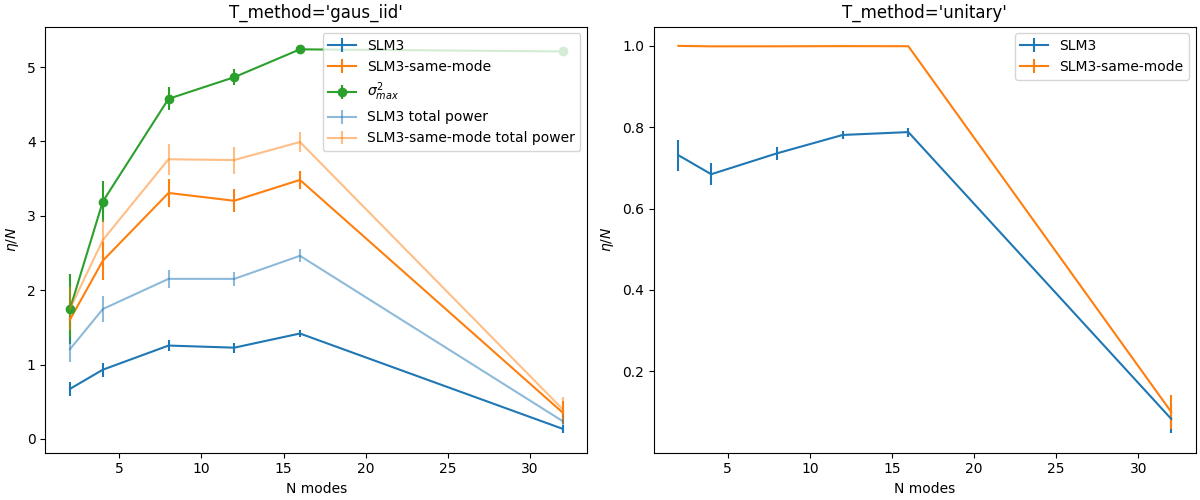

In [113]:
paths = glob.glob(rf'{DATA_DIR}\N_dep\*_Nmodes_*')
ress = [QWFSResult(path) for path in paths]
Ns = np.array([re.findall('.*Nmodes_(\d+).npz', path)[0] for path in paths]).astype(float)
Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))
print(Ns)

# TODO: colors similar to other figures 

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))

for ax, T_method in zip(axes, ress[0].T_methods[::-1]):
    effs_SLM3 = np.zeros_like(Ns)
    stds_SLM3 = np.zeros_like(Ns)
    tot_I_outs_SLM3 = np.zeros_like(Ns)
    tot_I_outs_std_SLM3 = np.zeros_like(Ns)
    effs_SLM3_OPC = np.zeros_like(Ns)
    stds_SLM3_OPC = np.zeros_like(Ns)
    tot_I_outs_SLM3_OPC = np.zeros_like(Ns)
    tot_I_outs_std_SLM3_OPC = np.zeros_like(Ns)
    max_SVDs = np.zeros_like(Ns)
    max_SVDs_std = np.zeros_like(Ns)

    alg_ind = np.where(ress[0].algos == 'autograd-lbfgs')[0]
    T_method_ind = np.where(ress[0].T_methods == T_method)[0]

    for i, N in enumerate(Ns):
        res = ress[i]
        effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
        effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std() / np.sqrt(res.results.shape[2])
        
        tot_I_outs = res.tot_power_results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
        tot_I_outs_SLM3[i] = tot_I_outs.mean(); tot_I_outs_std_SLM3[i] = tot_I_outs.std() / np.sqrt(res.results.shape[2])
        
        effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
        tot_I_outs = res.tot_power_results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
        effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std() / np.sqrt(res.results.shape[2])
        tot_I_outs_SLM3_OPC[i] = tot_I_outs.mean(); tot_I_outs_std_SLM3_OPC[i] = tot_I_outs.std() / np.sqrt(res.results.shape[2])

        if T_method == 'gaus_iid':
            T_method_no = np.where(ress[0].T_methods == 'gaus_iid')[0][0]
            these_svds = res.max_SVDs[T_method_no::2]
            max_SVDs[i] = these_svds.mean()**2 
            max_SVDs_std[i] = these_svds.std()**2 
            
    lines = ax.errorbar(Ns, effs_SLM3, stds_SLM3, label='SLM3')
    lines_OPC = ax.errorbar(Ns, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-same-mode')
    if T_method == 'gaus_iid':
        ax.errorbar(Ns, max_SVDs, max_SVDs_std, label=r'$\sigma_{max}^2$', marker='o')
        ax.errorbar(Ns, tot_I_outs_SLM3, tot_I_outs_std_SLM3, label='SLM3 total power', color=lines[0].get_c(), alpha=0.5)
        ax.errorbar(Ns, tot_I_outs_SLM3_OPC, tot_I_outs_std_SLM3_OPC, label='SLM3-same-mode total power', color=lines_OPC[0].get_c(), alpha=0.5)

    ax.legend()
    ax.set_xlabel('N modes')
    ax.set_ylabel('$\eta/N$')
    ax.set_title(f'{T_method=}') 
    
fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\N_dependence.png")

# 8) incopmlete control 

In [ ]:
pass

## 8.1 little control limit 

In [ ]:
pass

# Old

# Vary degree of control

In [51]:
plt.close('all')
import re 
def get_N_pixs_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    Ns = np.array([re.findall('.*N_pixels_(\d+).npz', path)[0] for path in paths]).astype(float)
    Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))
    return np.array(Ns), np.array(ress)


def show_N_pix_dependance(N_pixs, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False, ylim=None, show_tot_power=False, show_max_SVDs=False):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab10')  # Use a colormap, 'tab10' gives distinct colors
    
    for T_method_no, T_method in enumerate(T_methods):
        tot_powers = np.zeros_like(N_pixs)
        effs = np.zeros_like(N_pixs)
        eff_stds = np.zeros_like(N_pixs)
        max_SVDs = np.zeros_like(N_pixs)
        max_SVDs = np.zeros_like(N_pixs)
        
        for i, N in enumerate(N_pixs):
            res = ress[i]
            I_outs, I_focuses = get_slm1_intensities(res, config=which_config, T_method=T_method, alg=which_optimization)
            effs[i] = I_focuses.mean()
            eff_stds[i] = I_focuses.std()
            tot_powers[i] = I_outs.sum(axis=1).mean()
            these_Ts = res.Ts[T_method_no::2]
            if show_max_SVDs:
                max_SVDs[i] = np.array([np.linalg.svd(T@T.transpose(), compute_uv=False).max() for T in these_Ts]).mean()**2 # mean of max_svd^2
        
        y_err = eff_stds
        if not full_std:
            y_err /= np.sqrt(res.results.shape[2])
        
        base_color = cmap(T_method_no % 10)  # Cycle through colors in colormap
        ax.errorbar(N_pixs, effs, yerr=y_err, label=T_method, marker='o', color=base_color)
        if show_tot_power:
            # tot_power_color = [min(1, c + 0.1) for c in base_color[:3]] + [base_color[3]]  # Lighten the color
            amount = 0.2 
            tot_power_color = [(1 - amount) * c + amount for c in base_color[:3]] + [base_color[3]] 
            ax.plot(N_pixs, tot_powers, label=f'{T_method}-tot power', marker='o', linestyle='--', color=tot_power_color)
            
        if show_max_SVDs:
            amount = 0.4 
            SVD_color = [(1 - amount) * c + amount for c in base_color[:3]] + [base_color[3]] 
            ax.plot(N_pixs, max_SVDs, label=f'{T_method}-max-SVD', marker='o', linestyle='-.', color=SVD_color)
        
    ax.legend()    
    ax.set_xlabel('N_pixels')
    ax.set_ylabel('Intensity')
    ax.set_title(f'{which_optimization=}, {which_config=}')
    
def fig3(N_pixs, ress):
    DOCs = N_pixs / ress[0].N_modes
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))
    
    for ax, T_method in zip(axes, ress[0].T_methods):
        effs_SLM1 = np.zeros_like(N_pixs)
        stds_SLM1 = np.zeros_like(N_pixs)
        effs_SLM2 = np.zeros_like(N_pixs)
        stds_SLM2 = np.zeros_like(N_pixs)
        effs_SLM2_OPC = np.zeros_like(N_pixs)
        stds_SLM2_OPC = np.zeros_like(N_pixs)
        effs_SLM3 = np.zeros_like(N_pixs)
        stds_SLM3 = np.zeros_like(N_pixs)
        effs_SLM3_OPC = np.zeros_like(N_pixs)
        stds_SLM3_OPC = np.zeros_like(N_pixs)
        alg_ind = np.where(ress[0].algos == 'autograd')[0]
        T_method_ind = np.where(ress[0].T_methods == T_method)[0]
    
        for i, DOC in enumerate(DOCs):
            res = ress[i]
            # effs_SLM1[i] = res.results
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM1-only-T')[0], :, alg_ind].squeeze()
            effs_SLM1[i] = effs.mean(); stds_SLM1[i] = effs.std()
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2')[0], :, alg_ind].squeeze()
            effs_SLM2[i] = effs.mean(); stds_SLM2[i] = effs.std()
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2-simple-OPC')[0], :, alg_ind].squeeze()
            effs_SLM2_OPC[i] = effs.mean(); stds_SLM2_OPC[i] = effs.std()
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
            effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std()
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
            effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std()
            
        lines = ax.errorbar(DOCs, effs_SLM1, stds_SLM1, label='SLM1')
        ax.plot([0, 1], [0, np.pi/4], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM2, stds_SLM2, label='SLM2')
        ax.plot([0, 1], [0, (np.pi/4)**2], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM2_OPC, stds_SLM2_OPC, label='SLM2-OPC')
        ax.plot([0, 1], [0, 1], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM3, stds_SLM3, label='SLM3')
        ax.plot([0, 1], [0, effs_SLM3.max()], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-OPC')
        if T_method == 'gaus_iid':
            pass
            ax.plot([0, 1], [0, effs_SLM3_OPC.max()], color=lines[0].get_c(), linestyle='--', alpha=0.5)  
        ax.legend()
        ax.set_xlabel('degree of control')
        ax.set_ylabel('$\eta/N$')
        ax.set_title(f'{T_method=}') 
        
        ax.axhline(y=np.pi/4, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(y=(np.pi / 4) ** 2, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=1, color='black', linestyle='-', alpha=0.5)
        
    fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\incomplete_control.png")


In [44]:
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_12_24*several_configs*N_pixels*.npz'
N_pixs, ress = get_N_pixs_ress(glob_regex)

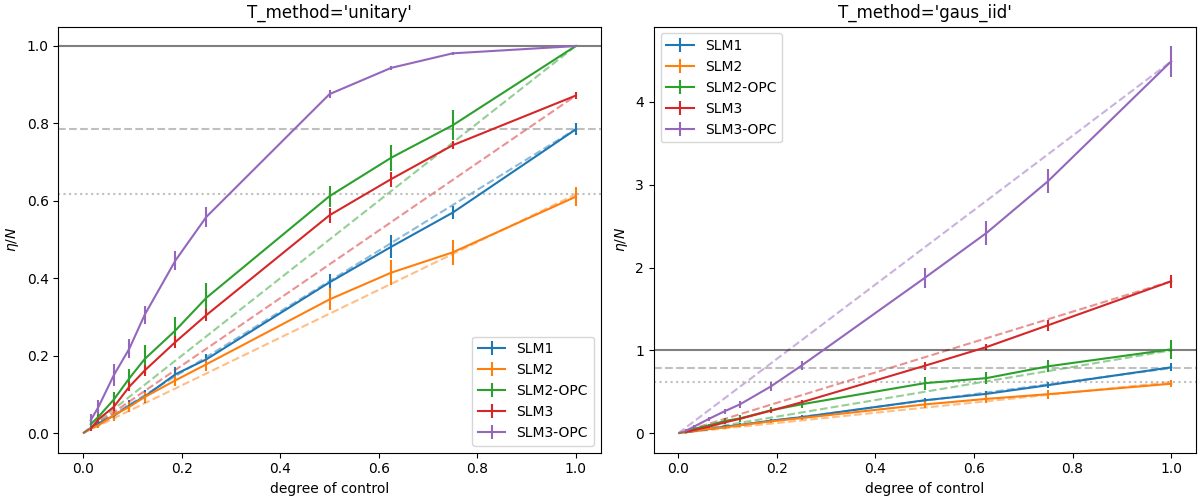

In [53]:
fig3(N_pixs, ress)
# plt.close('all')
# show_N_pix_dependance(N_pixs, ress, which_config='SLM1-only-T',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM2',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM2-simple-OPC',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM3',which_optimization='autograd', full_std=False, show_tot_power=True, show_max_SVDs=False)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM3-same-mode',which_optimization='autograd', full_std=False, show_tot_power=True, show_max_SVDs=False)